<a href="https://colab.research.google.com/github/Bien9x/DL-for-Bee/blob/main/Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers xformers git+https://github.com/huggingface/accelerate.git huggingface_hub diffusers["torch"]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


In [2]:
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel

from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
    FlaxDPMSolverMultistepScheduler,
    UniPCMultistepScheduler,
)
import torch
import requests
import torch
from PIL import Image
from io import BytesIO
import numpy as np
# first we need to login with our access token
#login()


## Init image

Original image


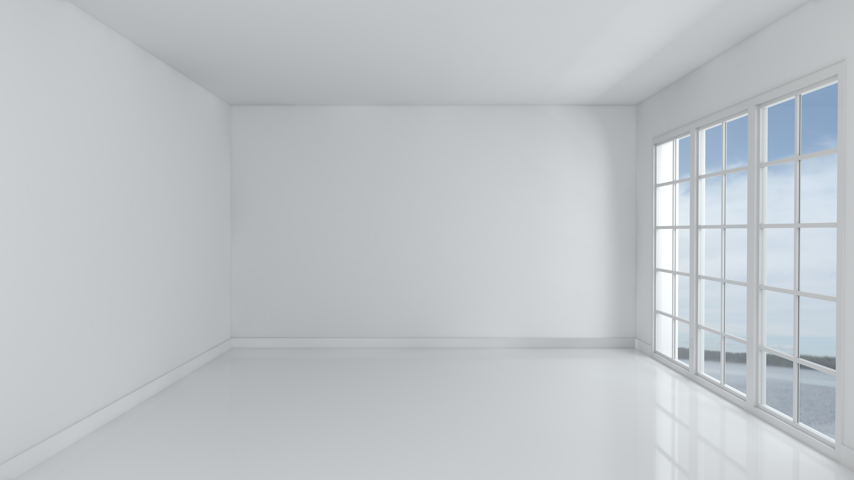

In [3]:
url = "https://images.wallpaperscraft.com/image/single/living_room_modern_design_70088_1600x900.jpg"

# response = requests.get(url)
#init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = Image.open('/content/empty-room-with-windows.jpg')
init_image = init_image.resize((854, 480))
print('Original image')
init_image.show()

In [17]:
prompt = "Interior Design, a perspective of a living room, modern furniture, modern interior design — ar 16:9" # Nordic, living room

## Style

Prompt hint: https://bootcamp.uxdesign.cc/30-best-midjourney-prompts-for-interior-design-a9d03ccaf9be

### Without Controlnet

In [ ]:
device = "cuda"
model_id_or_path = "prompthero/openjourney-v4"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)
#pipe.scheduler = FlaxDPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/37 [00:00<?, ?it/s]

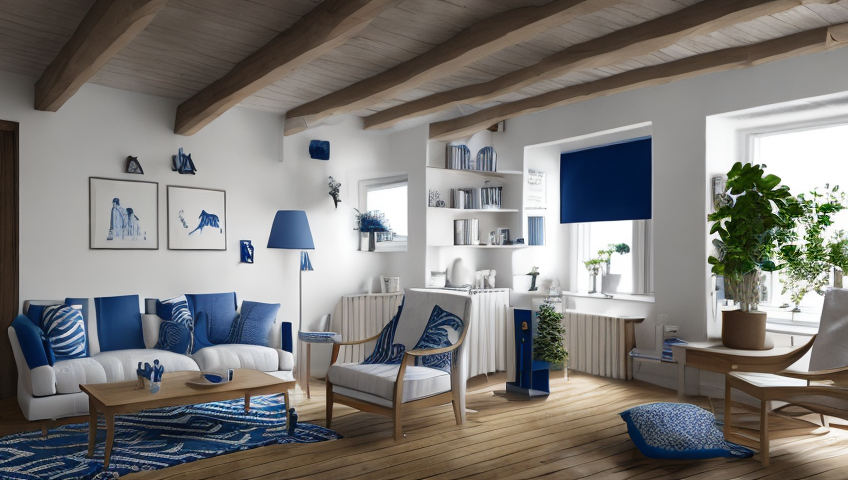

In [ ]:

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].show()

In [ ]:
# clear mem
import gc
del pipe
torch.cuda.empty_cache()
gc.collect()

68

### Controlnet: Depth

In [ ]:
# depth_estimator = pipeline('depth-estimation')


# image = depth_estimator(image)['depth']
# image = np.array(image)
# image = image[:, :, None]
# image = np.concatenate([image, image, image], axis=2)
# image = Image.fromarray(image)

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Depth image


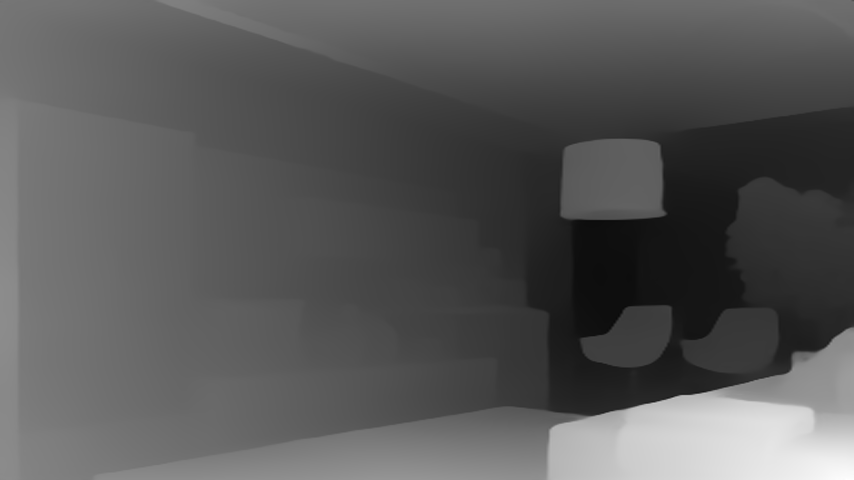

In [ ]:
from transformers import DPTForDepthEstimation, DPTFeatureExtractor
import numpy as np

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

# prepare image for the model
inputs = feature_extractor(images=init_image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=init_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
print("Depth image")
depth.show()


In [ ]:
# clear mem
import gc
del model
torch.cuda.empty_cache()
gc.collect()

30

In [ ]:
model_id = "prompthero/openjourney-v4"
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/16 [00:00<?, ?it/s]

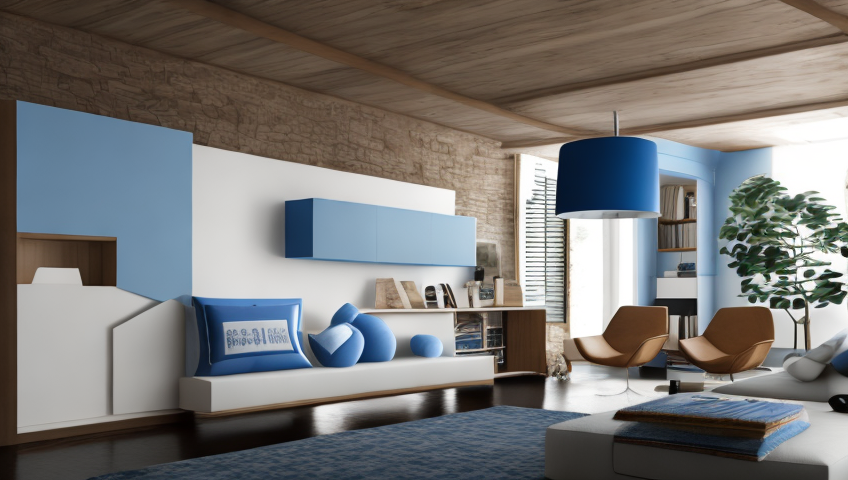

In [ ]:
generator = torch.manual_seed(42)
image = pipe(prompt,
            num_inference_steps=20,
            generator=generator,
            image=init_image,
            control_image=depth,
         ).images[0]
image

### Controlnet: Segment

In [25]:
# from transformers import pipeline

# from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# # load Mask2Former fine-tuned on COCO panoptic segmentation
# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

# inputs = processor(images=init_image, return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)

# # model predicts class_queries_logits of shape `(batch_size, num_queries)`
# # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
# class_queries_logits = outputs.class_queries_logits
# masks_queries_logits = outputs.masks_queries_logits

# # you can pass them to processor for postprocessing
# result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[init_image.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


In [26]:
# clear mem
import gc
del model
torch.cuda.empty_cache()
gc.collect()

422

In [31]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation


image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-base")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-base")


pixel_values = image_processor(init_image, return_tensors="pt").pixel_values

with torch.no_grad():
  outputs = image_segmentor(pixel_values)

seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[init_image.size[::-1]])[0]

color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

import gc
del image_processor, image_segmentor, pixel_values
torch.cuda.empty_cache()
gc.collect()

233

In [6]:
palette = np.asarray([
    [0, 0, 0],
    [120, 120, 120],
    [180, 120, 120],
    [6, 230, 230],
    [80, 50, 50],
    [4, 200, 3],
    [120, 120, 80],
    [140, 140, 140],
    [204, 5, 255],
    [230, 230, 230],
    [4, 250, 7],
    [224, 5, 255],
    [235, 255, 7],
    [150, 5, 61],
    [120, 120, 70],
    [8, 255, 51],
    [255, 6, 82],
    [143, 255, 140],
    [204, 255, 4],
    [255, 51, 7],
    [204, 70, 3],
    [0, 102, 200],
    [61, 230, 250],
    [255, 6, 51],
    [11, 102, 255],
    [255, 7, 71],
    [255, 9, 224],
    [9, 7, 230],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [7, 255, 224],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [255, 122, 8],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
    [31, 255, 0],
    [255, 31, 0],
    [255, 224, 0],
    [153, 255, 0],
    [0, 0, 255],
    [255, 71, 0],
    [0, 235, 255],
    [0, 173, 255],
    [31, 0, 255],
    [11, 200, 200],
    [255, 82, 0],
    [0, 255, 245],
    [0, 61, 255],
    [0, 255, 112],
    [0, 255, 133],
    [255, 0, 0],
    [255, 163, 0],
    [255, 102, 0],
    [194, 255, 0],
    [0, 143, 255],
    [51, 255, 0],
    [0, 82, 255],
    [0, 255, 41],
    [0, 255, 173],
    [10, 0, 255],
    [173, 255, 0],
    [0, 255, 153],
    [255, 92, 0],
    [255, 0, 255],
    [255, 0, 245],
    [255, 0, 102],
    [255, 173, 0],
    [255, 0, 20],
    [255, 184, 184],
    [0, 31, 255],
    [0, 255, 61],
    [0, 71, 255],
    [255, 0, 204],
    [0, 255, 194],
    [0, 255, 82],
    [0, 10, 255],
    [0, 112, 255],
    [51, 0, 255],
    [0, 194, 255],
    [0, 122, 255],
    [0, 255, 163],
    [255, 153, 0],
    [0, 255, 10],
    [255, 112, 0],
    [143, 255, 0],
    [82, 0, 255],
    [163, 255, 0],
    [255, 235, 0],
    [8, 184, 170],
    [133, 0, 255],
    [0, 255, 92],
    [184, 0, 255],
    [255, 0, 31],
    [0, 184, 255],
    [0, 214, 255],
    [255, 0, 112],
    [92, 255, 0],
    [0, 224, 255],
    [112, 224, 255],
    [70, 184, 160],
    [163, 0, 255],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [255, 0, 143],
    [0, 255, 235],
    [133, 255, 0],
    [255, 0, 235],
    [245, 0, 255],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 41, 255],
    [0, 255, 204],
    [41, 0, 255],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [122, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [0, 133, 255],
    [255, 214, 0],
    [25, 194, 194],
    [102, 255, 0],
    [92, 0, 255],
])


In [32]:
# seg = result['segmentation'].numpy()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

color_seg = color_seg.astype(np.uint8)

seg_image = Image.fromarray(color_seg)

Segment image


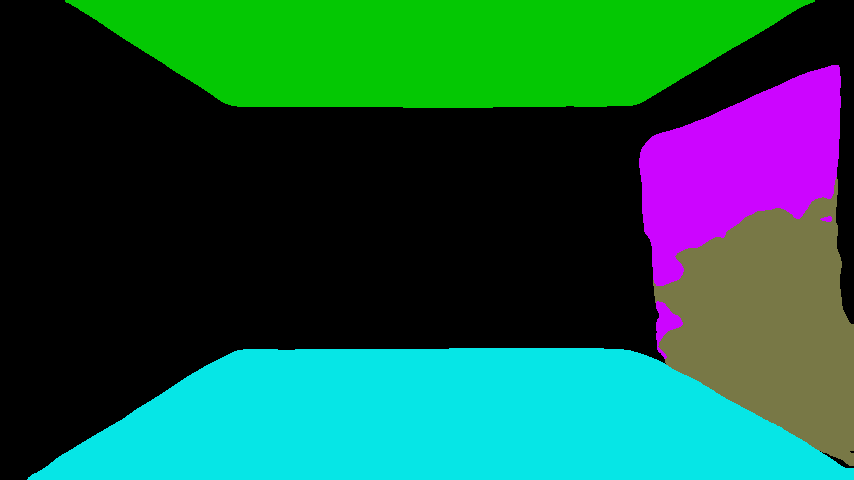

In [33]:
print('Segment image')
seg_image

In [14]:
# clear mem
# import gc
# del model
# torch.cuda.empty_cache()
# gc.collect()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'model' is not defined

In [34]:
#model_id = "prompthero/openjourney-v4"
model_id = "runwayml/stable-diffusion-v1-5"
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:631 in                │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   628 │   │   │   │   │   │   │   )                                                              │
│   629 │   │   │   │   │   │                                                                      │
│   630 │   │   │   │   │   │   if accepts_dtype:                                                  │
│ ❱ 631 │   │   │   │   │   │   │   set_module_tensor_to_device(                                   │
│   632 │   │   │   │   │   │   │   │   model, param_name, param_device, value=param, dtype=torc   │
│   633 │   │   │   │   │   │   │   )                                                              │
│   634 │   │   │   │   │   │   else:                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:161 in                      │
│ set_module_tensor_to_device                                                                      │
│                                                                                                  │
│    158 │   │   │   # For compatibility with PyTorch load_state_dict which converts state dict d  │
│    159 │   │   │   value = value.to(old_value.dtype)                                             │
│    160 │   │   elif not str(value.dtype).startswith(("torch.uint", "torch.int", "torch.bool")):  │
│ ❱  161 │   │   │   value = value.to(dtype)                                                       │
│    162 │                                                                                         │
│    163 │   with torch.no_grad():                                                                 │
│    164 │   │   if value is None:                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

  0%|          | 0/16 [00:00<?, ?it/s]

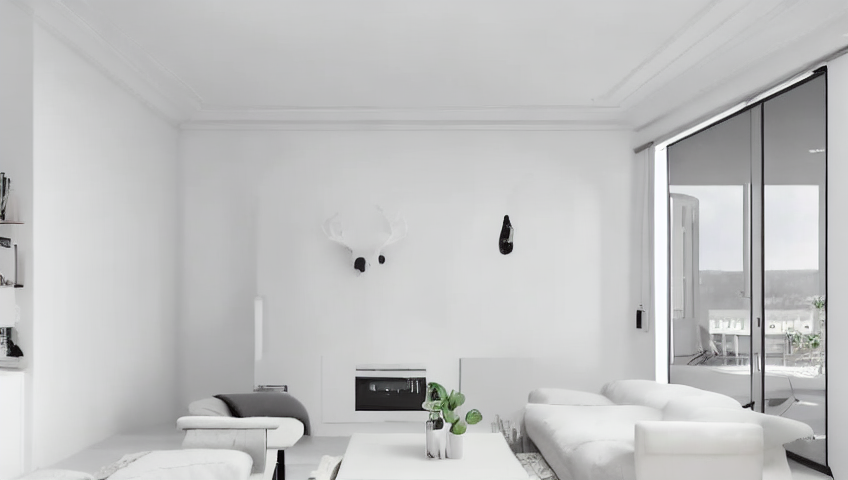

In [48]:
prompt = "Interior Design of a living room, nordic style — ar 16:9"
negative_prompt = "unnatural colors, poor lighting, wrong dimmension, out of frame"
generator = torch.manual_seed(2024)
image = pipe(prompt,
            num_inference_steps=20,
            generator=generator,
            image=init_image,
            negative_prompt=negative_prompt,
            control_image=seg_image,
            controlnet_conditioning_scale = 0.5

         ).images[0]
image

In [49]:
import gc
del pipe
torch.cuda.empty_cache()
gc.collect()

15521

#Edge

In [4]:
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.8 MB/s eta 0:00:00


In [11]:
from controlnet_aux import HEDdetector, MLSDdetector

#hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')
mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')
edge_image = mlsd(init_image)
del mlsd
import gc
torch.cuda.empty_cache()
gc.collect()

13306

In [12]:
#model_id = "prompthero/openjourney-v4"
model_id = "runwayml/stable-diffusion-v1-5"
#controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
#pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:449 in _make_request           │
│                                                                                                  │
│    446 │   │   │   │   │   # Remove the TypeError from the exception chain in                    │
│    447 │   │   │   │   │   # Python 3 (including for exceptions like SystemExit).                │
│    448 │   │   │   │   │   # Otherwise it looks like a bug in the code.                          │
│ ❱  449 │   │   │   │   │   six.raise_from(e, None)                                               │
│    450 │   │   except (SocketTimeout, BaseSSLError, SocketError) as e:                           │
│    451 │   │   │   self._raise_timeout(err=e, url=url, timeout_value=read_timeout)               │
│    452 │   │   │   raise                                                                         │
│ in raise_from:3                                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:444 in _make_request           │
│                                                                                                  │
│    441 │   │   │   except TypeError:                                                             │
│    442 │   │   │   │   # Python 3                                                                │
│    443 │   │   │   │   try:                                                                      │
│ ❱  444 │   │   │   │   │   httplib_response = conn.getresponse()                                 │
│    445 │   │   │   │   except BaseException as e:                                                │
│    446 │   │   │   │   │   # Remove the TypeError from the exception chain in                    │
│    447 │   │   │   │   │   # Python 3 (including for exceptions like SystemExit).                │
│                                                                                                  │
│ /usr/lib/python3.10/http/client.py:1375 in getresponse                                           │
│                                                                                                  │
│   1372 │   │                                                                                     │
│   1373 │   │   try:                                                                              │
│   1374 │   │   │   try:                                                                          │
│ ❱ 1375 │   │   │   │   response.begin()                                                          │
│   1376 │   │   │   except ConnectionError:                                                       │
│   1377 │   │   │   │   self.close()                                                              │
│   1378 │   │   │   │   raise                                                                     │
│                                                                                                  │
│ /usr/lib/python3.10/http/client.py:318 in begin                                                  │
│                                                                                                  │
│    315 │   │                                                                                     │
│    316 │   │   # read until we get a non-100 response                                            │
│    317 │   │   while True:                                                                       │
│ ❱  318 │   │   │   version, status, reason = self._read_status()                                 │
│    319 │   │   │   if status != CONTINUE:                                                        │
│    320 │   │   │   │   break                               